# Classification and cleaning of 16S data in LP4 after re-demultiplexing

1. remove short sequences (qiime-feature-table filter-seqs)
2. classification
3. remove chloroplasts and mitochondria from 16S (qiime taxa filter-table)
4. run decontam
5. remove (obvious, contaminated) outliers
6. remove any sequences that are not bacterial
7. perform alpha rarefaction

-->> decided to proceed with dada2 for 16S

In [1]:
import os
import qiime2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
print("Current working directory:", os.getcwd())

Current working directory: /home/meyeanni


In [2]:
import os
import qiime2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the working directory
wd = '/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S'

# Change to the working directory
os.chdir(wd)

# Verify current working directory
print("Current working directory:", os.getcwd())

Current working directory: /home/meyeanni/cloud/meyeanni/LP4/artifacts/16S


In [3]:
import qiime2 as q2

from qiime2 import (Artifact,
                    Metadata as qmd)

from qiime2.plugins import (cutadapt,
                            demux,
                            feature_table as qft,
                            taxa as q2t,)

from qiime2 import Metadata
from qiime2 import Visualization

from qiime2.plugins.feature_table.methods import (merge_seqs, merge, filter_seqs, filter_samples, filter_features) 
import qiime2.plugins.feature_classifier.actions as feature_classifier_actions
import qiime2.plugins.metadata.actions as metadata_actions
import qiime2.plugins.taxa.actions as taxa_actions
import qiime2.plugins.phylogeny.actions as phylogeny_actions
from qiime2.plugins.fragment_insertion.methods import sepp


%matplotlib inline

# 1. remove very short reads


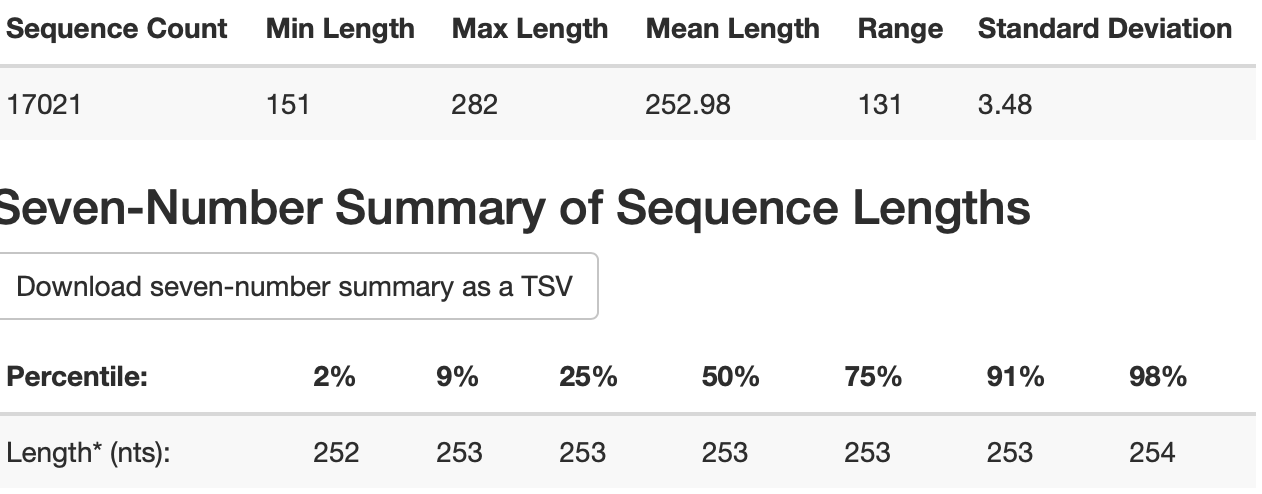


In [ ]:

#not necessary since the shortest read is 150 bp..
qiime feature-table filter-seqs \
  --i-data 16S/dada2/dada7-rep-seqs.qza \
  --p-min-length 50 \
  --o-filtered-data filtered-rep-seqs.qza

I realized that the sample IDS are like this: 366293_373-LP4-16S-0373_S845, which means to more efficiently proceed with merging and so on I first need to truncate all IDs to the first 23 characters and then continue again with classification. This will be easier to do now before prceeding with processing, since otherwise in each step it would need to be done before merging with metadata...

first: export the artifacts:

In [ ]:
qiime tools export --input-path dada2-rep-seqs.qza --output-path exported_rep_seqs
qiime tools export --input-path dada2-stats.qza --output-path exported_stats
qiime tools export --input-path dada2-table.qza --output-path exported_table


now, convert the feature table and change ids

In [ ]:
biom convert -i exported_table/feature-table.biom -o feature-table.tsv --to-tsv


In [15]:
#something went wrong (also feature ids were truncated which is really bad. therefore I decided to modify the tsv drectly in excel to be sure that it doesn't happen again...)
#import pandas as pd

# Load the feature table
#df = pd.read_csv('dada2/feature-table.tsv', sep='\t', skiprows=1)

# Rename the sample IDs (first column is sample IDs)
#df.columns = [col[:23] if col != "#OTU ID" else col for col in df.columns]

# Save the modified table
#df.to_csv('dada2/modified-feature-table.tsv', sep='\t', index=False)


In [ ]:
biom convert -i modified-feature-table.tsv -o feature-table.biom --to-hdf5


then do the same for the stats file: do it directly by opening the tsv and doing in excel

rep-seqs: do not have to be modified since there is only the feature id in the file but not the sample id, just continue with the previous re-seq file!!

Then re-import all the files to qiime2:

In [ ]:
#feature table:
qiime tools import --input-path feature-table.biom --type 'FeatureTable[Frequency]' --output-path modified-dada2-table.qza
#stats:
qiime tools import --input-path exported_stats/stats.tsv --type 'SampleData[DADA2Stats]' --output-path modified-dada2-stats.qza




In [ ]:
qiime metadata tabulate \
--m-input-file modified-dada2-stats.qza \
--o-visualization modified-dada2-stats.qzv
qiime feature-table summarize \
--i-table modified-dada2-table.qza \
--o-visualization modified-dada2-table.qzv


### then continue with the modified files for all subsequent analyses!!!

# 2. classify the sequences

In [4]:
! pwd

/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S


In [5]:
! mkdir hoi

In [6]:
## Load dada table and rep seqs  

# this is the `FeatureData[Sequence]` 
rep_seqs = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S/dada2/dada2-rep-seqs.qza')

# `FeatureTable[Frequency]` filtered after the aligned hits
table = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S/dada2/modified-dada2-table.qza')

In [7]:
fn = '/home/meyeanni/cloud/meyeanni/LP4_x/artifacts/16S/SILVA/silva-138.2-ssu-nr99-515f-806r-classifier.qza'
classifier = Artifact.load(fn)

In [8]:
# load metadata 
metadata = '/home/meyeanni/cloud/meyeanni/LP4/LP4_metadata.tsv'
md = Metadata.load(metadata)

In [19]:
taxonomy, = feature_classifier_actions.classify_sklearn(
    classifier=classifier,
    reads=rep_seqs,
    confidence=0,
    n_jobs=1  # Make sure this is a valid number of threads for your environment
)

taxonomy_as_md_md = taxonomy.view(Metadata)
taxonomy_viz, = metadata_actions.tabulate(
    input=taxonomy_as_md_md,
)

taxonomy.save('sklearn/taxonomy_dada2.qza')
taxonomy_viz.save('sklearn/taxonomy_dada2.qzv')

'sklearn/taxonomy_dada2.qzv'

## 3. remove chloroplasts and mitochondria

In [9]:
taxonomy = q2.Artifact.load('sklearn/taxonomy_dada2.qza')

In [10]:
# filter features: exclude non-target seqs
exclude_terms = 'mitochondria,chloroplast,d__Eukaryota,d__Archaea'

In [11]:
taxa_filtered_table, = q2t.actions.filter_table(
                                table=table, 
                                taxonomy=taxonomy,
                                exclude=exclude_terms)
taxa_filtered_table.save('sklearn/taxa_filtered_table_dada2.qza')

'sklearn/taxa_filtered_table_dada2.qza'

In [12]:
!qiime feature-table summarize \
  --i-table sklearn/taxa_filtered_table_dada2.qza \
  --o-visualization sklearn/taxa_filtered_table_dada2.qzv

Saved Visualization to: sklearn/taxa_filtered_table_dada2.qzv


In [13]:
filtered_rep_seqs, = q2t.actions.filter_seqs(sequences=rep_seqs, 
                                taxonomy=taxonomy,
                                exclude=exclude_terms)
filtered_rep_seqs.save('sklearn/filtered_rep_seqs_dada2.qza')

'sklearn/filtered_rep_seqs_dada2.qza'

In [ ]:
# qiime feature-table tabulate-seqs \
#   --i-data sklearn/filtered_rep_seqs.qza \
#   --o-visualization tax_tests/unmatched-seqs.qzv

check that it is actually removed

In [14]:
import qiime2
import pandas as pd

# Load the taxonomy .qza file
# Load the taxonomy .qza file
taxonomy_artifact_sklearn = qiime2.Artifact.load('sklearn/taxonomy_dada2.qza')
feature_table = qiime2.Artifact.load('sklearn/taxa_filtered_table_dada2.qza')


# Extract the data as a pandas DataFrame
taxonomy_sklearn = taxonomy_artifact_sklearn.view(pd.DataFrame)
feature_table = feature_table.view(pd.DataFrame)

# Transpose the DataFrame
feature_table_t = feature_table.T
# Reset the index to make 'Feature ID' a column again
feature_table_t.reset_index(inplace=True)
feature_table_t.rename(columns={'index': 'Feature ID'}, inplace=True)
feature_table_t

taxonomy_sklearn.reset_index(inplace=True)
taxonomy_sklearn

# Extract the 'Family' level from the taxonomy string
taxonomy_sklearn['Domain'] = taxonomy_sklearn['Taxon'].str.split(';').str[0]

# Merge the feature table and taxonomy on the 'Feature ID' column
merged_data = pd.merge(feature_table_t, taxonomy_sklearn[['Feature ID', 'Domain']], left_on='Feature ID', right_on='Feature ID')

# Select only numeric columns for summation (i.e., sample columns)
numeric_columns = merged_data.select_dtypes(include=['number']).columns

# Group by 'Family' and sum feature counts, then reset the index
feature_sums = merged_data.groupby('Domain')[numeric_columns].sum().sum(axis=1).reset_index()

# Rename the columns for clarity
feature_sums.columns = ['Domain', 'Total_Features']

# Calculate percentages
total_features = feature_sums['Total_Features'].sum()
feature_sums['Percentage'] = (feature_sums['Total_Features'] / total_features) * 100# Calculate percentages


# Display the aggregated data
print(feature_sums)

        Domain  Total_Features  Percentage
0  d__Bacteria      13886003.0       100.0


-> looks fine!

## 4. run decontam

in plugin quality-control: https://docs.qiime2.org/2024.5/plugins/available/quality-control/decontam-identify-batches/


to be able to run the decontam command, all entries from the metadata which have no entry in the taxa_filtered_table_dada2.qzv have to be removed from the metadata, otherwise errors will occur..

In [ ]:
qiime tools export \
  --input-path sklearn/taxa_filtered_table_dada2.qza \
  --output-path sklearn/exported_table

In [ ]:
biom convert \
  -i sklearn/exported_table/feature-table.biom \
  -o sklearn/exported_table/feature-table.tsv \
  --to-tsv


make a new tsv file with ids to keep (copy column headers of previous feature table since it did not work to directly import...)

In [26]:
# Define the working directory
wd = '/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S/decontam'

# Change to the working directory
os.chdir(wd)

# Verify current working directory
print("Current working directory:", os.getcwd())

Current working directory: /home/meyeanni/cloud/meyeanni/LP4/artifacts/16S/decontam


In [27]:
import pandas as pd

# Load the file with IDs to keep
ids_to_keep_df = pd.read_csv('16S_ids.tsv', sep='\t')

# Load the metadata file
metadata_df = pd.read_csv('LP4_metadata_16S.tsv', sep='\t')

# Convert both ID columns to sets for efficient filtering
ids_to_keep = set(ids_to_keep_df['ids'])
metadata_ids = metadata_df[metadata_df.columns[0]]  # Assuming the first column contains the sample IDs

# Filter the metadata to only keep rows with IDs present in the 'ids_to_keep'
filtered_metadata_df = metadata_df[metadata_ids.isin(ids_to_keep)]

# Save the filtered metadata to a new file
filtered_metadata_df.to_csv('filtered_LP4_metadata_16S.tsv', sep='\t', index=False)

print(f"Filtered metadata saved to 'filtered_LP4_metadata_16S.tsv'.")


Filtered metadata saved to 'filtered_LP4_metadata_16S.tsv'.


--> then remove all entries that are not related to the highschool or evo or shipping exp, plus make sure that controls are properly labelled (including empty wells that can be treated as controls too, try both once inlcuding them for decontam and once excluding them)

filter feature table

In [15]:
! qiime feature-table filter-samples \
  --i-table sklearn/taxa_filtered_table_dada2.qza \
  --m-metadata-file decontam/filtered_LP4_metadata_16S_my_exp.tsv \
  --o-filtered-table decontam/filtered_taxa_table_16S_my_exp.qza


Saved FeatureTable[Frequency] to: decontam/filtered_taxa_table_16S_my_exp.qza


filter rep-seqs

In [16]:
! qiime feature-table filter-seqs \
  --i-data sklearn/filtered_rep_seqs_dada2.qza \
  --i-table decontam/filtered_taxa_table_16S_my_exp.qza \
  --o-filtered-data decontam/filtered_rep_seqs_16S_my_exp.qza



Saved FeatureData[Sequence] to: decontam/filtered_rep_seqs_16S_my_exp.qza


tune parameters: to do decontam with combined method, the metadata needs to be prepared first to contain frequency information:

In [ ]:
qiime feature-table summarize \
  --i-table decontam/filtered_taxa_table_16S_my_exp.qza \
  --o-visualization decontam/filtered_taxa_table_16S_my_exp.qzv


In [18]:
! qiime tools export \
  --input-path decontam/filtered_taxa_table_16S_my_exp.qza \
  --output-path decontam/filtered_taxa_table_exported

Exported decontam/filtered_taxa_table_16S_my_exp.qza as BIOMV210DirFmt to directory decontam/filtered_taxa_table_exported


In [19]:
! biom convert \
  -i decontam/filtered_taxa_table_exported/feature-table.biom \
  -o decontam/filtered_taxa_table.csv \
  --to-tsv


In [21]:
import pandas as pd
from biom import load_table

# Load the biom file
biom_table = load_table('decontam/filtered_taxa_table_exported/feature-table.biom')

# Convert to DataFrame
df = biom_table.to_dataframe()
df = df.fillna(0)  # Replace NaNs with 0

# Sum read counts per sample
feature_frequency = df.sum(axis=0).reset_index()
feature_frequency.columns = ['SampleID', 'TotalObservedFeatures']

# Save to CSV if needed
feature_frequency.to_csv('feature_frequency.csv', index=False)

In [22]:
# Count unique features (i.e., count columns with non-zero values)
unique_features_count = (df > 0).astype(int).sum(axis=0).reset_index()
unique_features_count.columns = ['SampleID', 'UniqueFeaturesCount']
# Save to CSV if needed
unique_features_count.to_csv('decontam/unique_features_count.csv', index=False)

In [23]:
metadata = pd.read_csv('decontam/filtered_LP4_metadata_16S_my_exp.tsv', sep='\t')  # Adjust sep if necessary
merged_df1 = pd.merge(metadata, unique_features_count, on='SampleID', how='left')
merged_df = pd.merge(merged_df1, feature_frequency, on='SampleID', how='left')

print(merged_df)
merged_df.to_csv('decontam/unique_features_frequency.csv', index=False)


                    SampleID label_barcode1 label_barcode2      created_date  \
0    366293_001-LP4-16S-0001   CAAGTCGTTTAC   AGCCTTCGTCGC  16.10.2024 14:59   
1    366293_002-LP4-16S-0002   AAGTTCGCGCTA   TTCCTTAGTAGT  16.10.2024 14:59   
2    366293_004-LP4-16S-0004   GCGGGCCTTTGC   TACGGATTATGG  16.10.2024 14:59   
3    366293_007-LP4-16S-0007   ACTTGCCCTCAC   GGTTCATGAACA  16.10.2024 14:59   
4    366293_008-LP4-16S-0008   CCGATCCATTAA   AATGGTTCAGCA  16.10.2024 14:59   
..                       ...            ...            ...               ...   
538  366294_264-LP4-16S-0764   TGACGGACATCT   TCTCTTTCGACA  16.10.2024 14:59   
539  366294_265-LP4-16S-0765   ACTGAATAACGA   CAAACGCACTAA  16.10.2024 14:59   
540  366294_266-LP4-16S-0766   CACATGCCTAAG   TTACTGTGGCCG  16.10.2024 14:59   
541  366294_267-LP4-16S-0767   GATCTGGGTTGG   TGAGTATGAGTA  16.10.2024 14:59   
542  366294_268-LP4-16S-0768   CAACGCAGTTTG   TGAGTCATTGAG  16.10.2024 14:59   

    amplicon     unique_id  sample_id p

Ok re-run once with the combined method (including bar plots)  subsequently make new barplots (just change names in the following commands.. and change metadata file so that it contains the frequency information) -->> go with 0.02 p-threshold and decontam1 including empty wells as negative controls (this removes nearly not reads, but increasing threshold would remove L. sanfranciscensis...)

In [24]:
!qiime quality-control decontam-identify \
--i-table decontam/filtered_taxa_table_16S_my_exp.qza \
--m-metadata-file decontam/16S_unique_features_frequency.tsv \
--p-method combined \
--p-freq-concentration-column UniqueFeaturesCount \
--p-prev-control-column decontam_1 \
--p-prev-control-indicator control_n \
--o-decontam-scores decontam/batch_effects/decontam_scores_decontam_1_comb.qza

Saved FeatureData[DecontamScore] to: decontam/batch_effects/decontam_scores_decontam_1_comb.qza


In [26]:
! qiime quality-control decontam-score-viz \
--i-decontam-scores decontam/batch_effects/decontam_scores_decontam_1_comb.qza \
--i-table decontam/filtered_taxa_table_16S_my_exp.qza \
--i-rep-seqs decontam/filtered_rep_seqs_16S_my_exp.qza \
--p-threshold 0.02 \
--p-weighted \
--p-bin-size 0.01 \
--o-visualization decontam/batch_effects/decontam_comb_0.02.qzv

Saved Visualization to: decontam/batch_effects/decontam_comb_0.02.qzv


also check out 0.04

In [27]:
! qiime quality-control decontam-score-viz \
--i-decontam-scores decontam/batch_effects/decontam_scores_decontam_1_comb.qza \
--i-table decontam/filtered_taxa_table_16S_my_exp.qza \
--i-rep-seqs decontam/filtered_rep_seqs_16S_my_exp.qza \
--p-threshold 0.04 \
--p-weighted \
--p-bin-size 0.01 \
--o-visualization decontam/batch_effects/decontam_comb_0.04.qzv

Saved Visualization to: decontam/batch_effects/decontam_comb_0.04.qzv


0.04 is very bad, it removes L. sanfranciscensis (at 0.02) and E. coli (which would be good) (at o.03), 

-->> therefore go with 0.02 which is just below the cutoff to loose L. sanfranciscensis.

In [28]:


! qiime quality-control decontam-remove \
--i-decontam-scores decontam/batch_effects/decontam_scores_decontam_1_comb.qza \
--i-table decontam/filtered_taxa_table_16S_my_exp.qza \
--i-rep-seqs decontam/filtered_rep_seqs_16S_my_exp.qza \
--p-threshold 0.02 \
--o-filtered-table decontam/filtered_taxa_table_16S_my_exp_decontam1_comb0.02.qza \
--o-filtered-rep-seqs decontam/filtered_rep_seqs_16S_my_exp_decontam1_comb0.02.qza

Saved FeatureTable[Frequency] to: decontam/filtered_taxa_table_16S_my_exp_decontam1_comb0.02.qza
Saved FeatureData[Sequence] to: decontam/filtered_rep_seqs_16S_my_exp_decontam1_comb0.02.qza


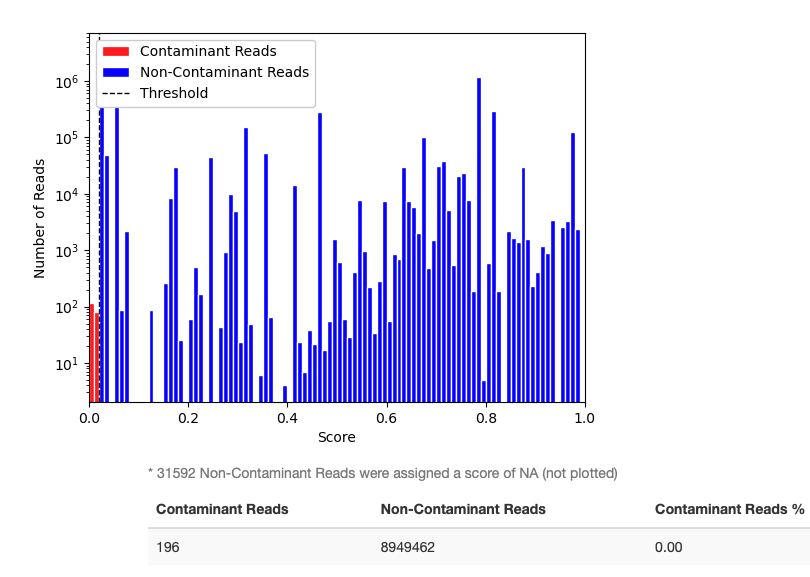

-> nearly no reads removed, but cannot go higher since otherwise L. sanfranciscensis is removed..

remake some barplots to check how samples look like now:

In [29]:
## Load dada table and rep seqs  

# this is the `FeatureData[Sequence]` 
rep_seqs_clean = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S/decontam/filtered_rep_seqs_16S_my_exp_decontam1_comb0.02.qza')

# `FeatureTable[Frequency]` filtered after the aligned hits
table_clean = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S/decontam/filtered_taxa_table_16S_my_exp_decontam1_comb0.02.qza')

In [11]:
#taxonomy:
# `FeatureTable[Frequency]` filtered after the aligned hits
taxonomy_dada2 = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S/sklearn/taxonomy_dada2.qza')

In [10]:
# load metadata 
metadata = '/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S/decontam/16S_unique_features_frequency.tsv'
md = Metadata.load(metadata)

In [32]:
# `FeatureTable[Frequency]` filtered after the aligned hits
table_clean = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S/decontam/filtered_taxa_table_16S_my_exp_decontam1_comb0.02.qza')
taxa_bar_plots_viz, = taxa_actions.barplot(
    table=table_clean,
    taxonomy=taxonomy_dada2,
    metadata=md,
)
taxa_bar_plots_viz.save('decontam/taxa_barplot_decontam1_comb0.02.qzv')

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  series[missing.index] = missing
/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

'decontam/taxa_barplot_decontam1_comb0.02.qzv'

check positive controls: there should be 8 species present: (and 2 yeast: Saccharomyces cerevisiae and Cryptococcus neoformans)
- Bacillus subtilis, yes
- Listeria monocytogenes, yes
- Staphylococcus aureus, yes
- Enterococcus faecalis, yes
- Lactobacillus fermentum, yes
- Salmonella enterica,  yes
- Escherichia coli, yes
- Pseudomonas aeruginosa, yes

-->> looks all good

## 5. continue with cleaning the data: filter out positive and negative controls

samples to continue: 

--o-filtered-table decontam/filtered_taxa_table_16S_my_exp_decontam1_comb0.02.qza \

--o-filtered-rep-seqs decontam/filtered_rep_seqs_16S_my_exp_decontam1_comb0.02.qza

In [34]:
! qiime feature-table filter-samples \
  --i-table decontam/filtered_taxa_table_16S_my_exp_decontam1_comb0.02.qza \
  --m-metadata-file decontam/unique_features_frequency_no_ctrl.tsv \
  --o-filtered-table decontam/bacteria-table-filt.qza

Saved FeatureTable[Frequency] to: decontam/bacteria-table-filt.qza


### 5.1 remove very low abundant ASVs

In [35]:
! qiime feature-table filter-features \
  --i-table decontam/bacteria-table-filt.qza \
  --p-min-frequency 10 \
  --p-min-samples 1 \
  --o-filtered-table decontam/bacteria-table-filt-1.qza

Saved FeatureTable[Frequency] to: decontam/bacteria-table-filt-1.qza


how many ASVs were removed? and how many reads?

In [4]:
# Load the taxonomy .qza file
bacteria_before = qiime2.Artifact.load('decontam/bacteria-table-filt.qza')
bacteria_after = qiime2.Artifact.load('decontam/bacteria-table-filt-1.qza')
taxonomy_artifact_sklearn = qiime2.Artifact.load('sklearn/taxonomy_dada2.qza')


# Extract the data as a pandas DataFrame
bacteria_b = bacteria_before.view(pd.DataFrame)
bacteria_a = bacteria_after.view(pd.DataFrame)
taxonomy_sklearn = taxonomy_artifact_sklearn.view(pd.DataFrame)



taxonomy_sklearn.reset_index(inplace=True)
taxonomy_sklearn

,Feature ID,Taxon,Confidence
0,2c628ab28244ea0a1abf54408590417d,d__Bacteria;p__Cyanobacteriota;c__Cyanobacteri...,0.14911837175096776
1,37239eacb119d556ba558e1661fed8c7,d__Bacteria;p__Bacillota;c__Clostridia;o__Lach...,0.00255483384874142
2,92c3ec4fb62a23de35e17f1745b0145f,d__Bacteria;p__Cyanobacteriota;c__Cyanobacteri...,0.16923624164748224
3,e8f345749725faa93454ab59a769940a,d__Bacteria;p__Cyanobacteriota;c__Cyanobacteri...,0.42007831885398533
4,dcc2c5d17313b4580fd420ad7aab7bca,d__Bacteria;p__Patescibacteria;c__Microgenomat...,0.005778648877983619
...,...,...,...
17016,5f639fb7b96bb67e26b818a43c91264d,d__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o_...,0.8688365238525788
17017,e1968660b9bdb64425ce3e77e7944e50,d__Bacteria;p__Planctomycetota;c__OM190;o__Inc...,0.8336926765374841
17018,c079cd0acf8bcde274ba3e0509e78c57,d__Bacteria;p__LCP-89;c__Incertae_Sedis;o__Inc...,0.2668702969561578
17019,0195cc10b4058646bac02de80047f793,d__Eukaryota;p__Discoba;c__Discicristata;o__Eu...,0.023037818525382264


Top 10 Removed Taxa:
                             Feature ID  \
8733   fd44d4cb468fd7dc9b3227867714ed87   
15798  b022b5312f30be684bdd2cc66030dea5   
9668   82dece6e35540738ba450a0c3a90b5a0   
15041  0c579d21280801f02a641e1608606927   
8740   b15193fce14759d1c06728933e044af6   
8539   310c718e15d222e7c0f644a4949499f8   
14428  9c0de7908dd6ef3d536b42d9e11e0779   
9987   a3022e8ed42cb33e0ee95f6c8277c17d   
16290  f7447c8e079023f4f2579d8580575dd3   
16968  9c21c0b1457379837c3a87a6f4443eff   

                                                   Taxon           Confidence  \
8733   d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...   0.4416883699226991   
15798  d__Bacteria;p__Bacillota;c__Negativicutes;o__V...   0.5954503399281512   
9668   d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...   0.2027783906272842   
15041  d__Bacteria;p__Actinomycetota;c__Actinobacteri...  0.30621734544360235   
8740   d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...   0.6606890719578608   
8539   d__Bacteria;

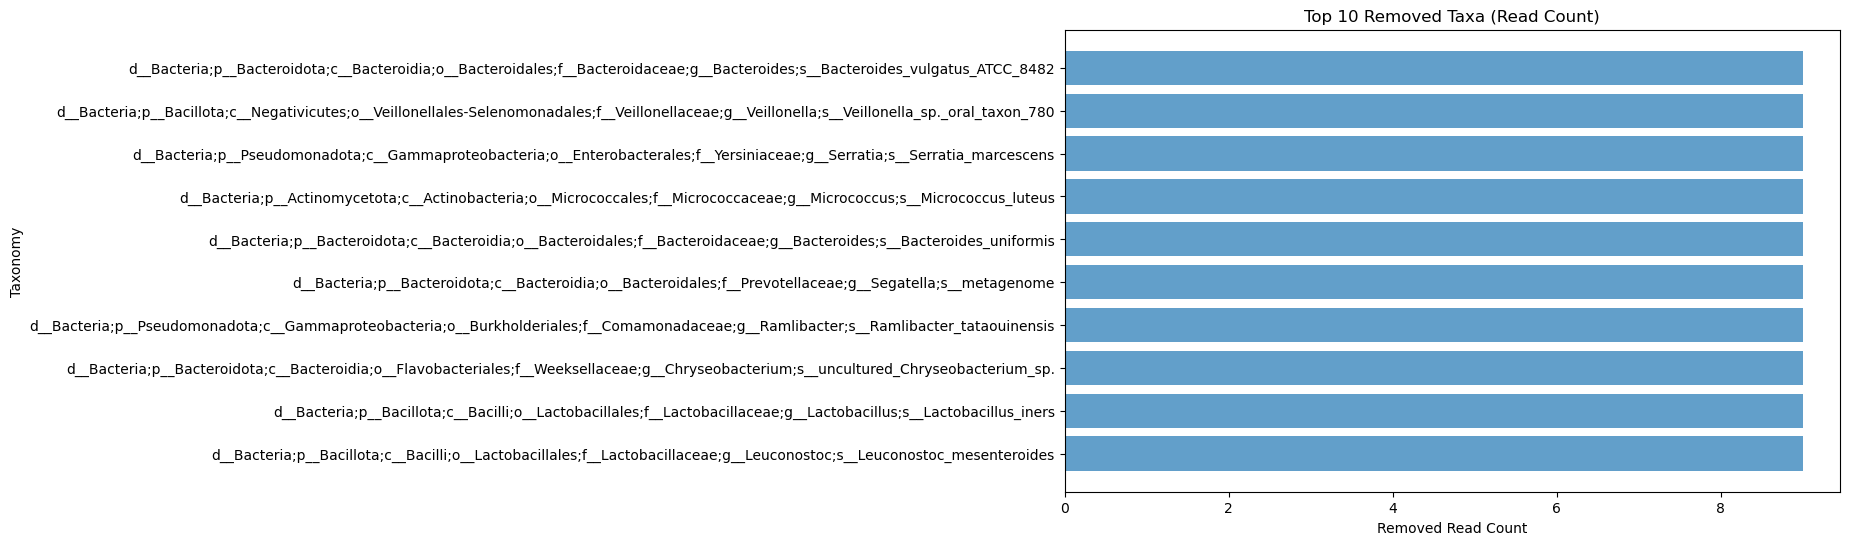

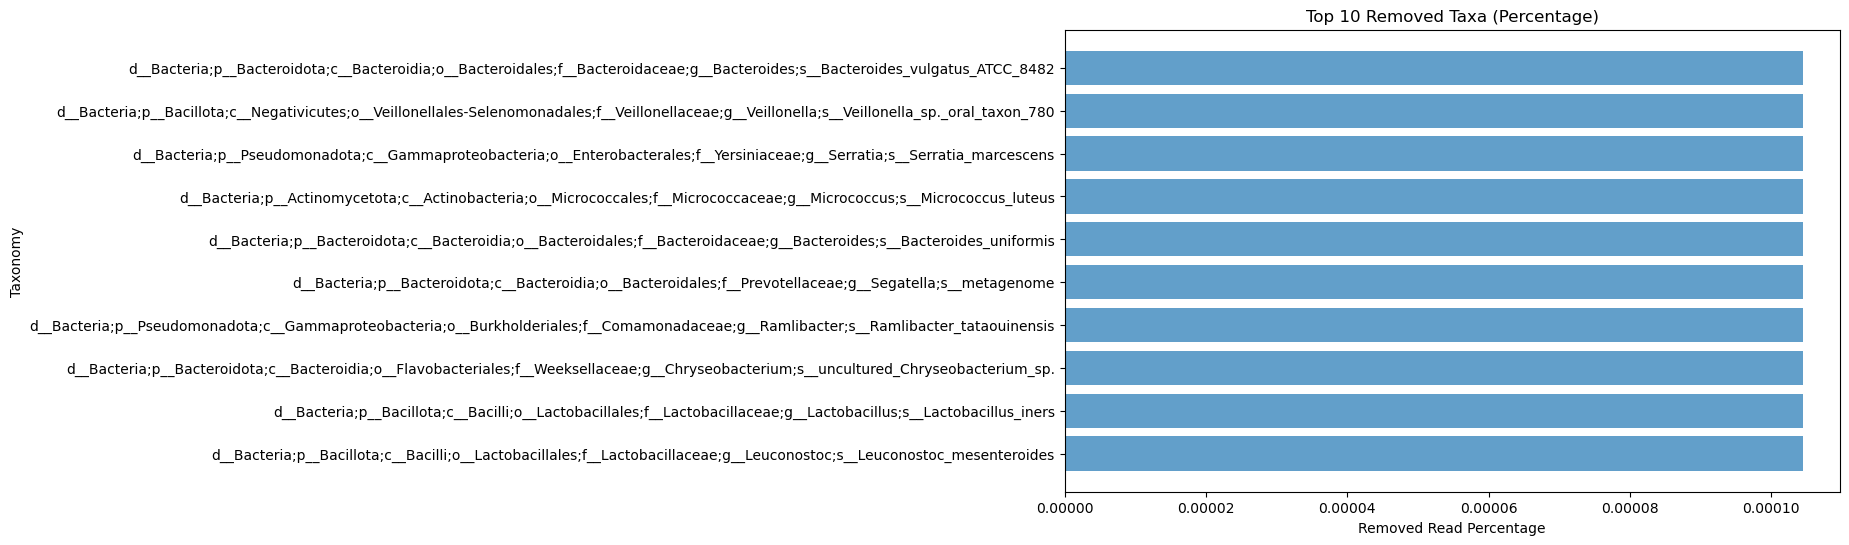

In [5]:
# Identify removed features
removed_features = set(bacteria_b.columns) - set(bacteria_a.columns)
removed_features_list = list(removed_features)
# Extract removed features and their taxonomy
removed_features_df = taxonomy_sklearn[taxonomy_sklearn['Feature ID'].isin(removed_features_list)]

# Calculate removed read counts for these features
removed_read_counts = bacteria_b[removed_features_list].sum()

# Merge taxonomy with removed read counts
removed_features_summary = removed_features_df.merge(
    removed_read_counts.rename("Removed Read Count"),
    left_on="Feature ID",
    right_index=True
)

# Calculate percentages
total_reads = bacteria_b.sum().sum()
removed_features_summary['Removed Read Percentage'] = (
    removed_features_summary['Removed Read Count'] / total_reads
) * 100

# Sort by read count
removed_features_summary_sorted = removed_features_summary.sort_values(by="Removed Read Count", ascending=False)

# Print the top 10 removed taxa
print("Top 10 Removed Taxa:")
print(removed_features_summary_sorted.head(10))

# Visualization: Counts and percentages of removed taxa
import matplotlib.pyplot as plt

top_removed = removed_features_summary_sorted.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_removed['Taxon'], top_removed['Removed Read Count'], alpha=0.7)
plt.xlabel('Removed Read Count')
plt.ylabel('Taxonomy')
plt.title('Top 10 Removed Taxa (Read Count)')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(top_removed['Taxon'], top_removed['Removed Read Percentage'], alpha=0.7)
plt.xlabel('Removed Read Percentage')
plt.ylabel('Taxonomy')
plt.title('Top 10 Removed Taxa (Percentage)')
plt.gca().invert_yaxis()
plt.show()

In [6]:
# Calculate feature frequencies and sample counts
feature_total_reads = bacteria_b.sum(axis=0)  # Total reads per feature
feature_sample_counts = (bacteria_b > 0).sum(axis=0)  # Number of samples each feature appears in

# Identify features to be removed based on filtering criteria
filtered_out_features = feature_total_reads[(feature_total_reads < 20) | (feature_sample_counts < 2)]
print(f"Number of features filtered out: {len(filtered_out_features)}")

# Verify overlap with the removed features
print(f"Overlap between filtered features and removed features: {len(set(filtered_out_features.index) & set(removed_features_list))}")


Number of features filtered out: 603
Overlap between filtered features and removed features: 489


In [7]:
# Inspect the top removed features
removed_features_summary_sorted = removed_features_summary.sort_values(by="Removed Read Count", ascending=False)
print(removed_features_summary_sorted.head(10))

# Cross-check taxonomy and counts for a specific feature if necessary
feature_id = removed_features_summary_sorted.iloc[0]['Feature ID']
print(f"Feature ID: {feature_id}")
print(f"Total Reads: {feature_total_reads[feature_id]}")
print(f"Sample Count: {feature_sample_counts[feature_id]}")

                             Feature ID  \
8733   fd44d4cb468fd7dc9b3227867714ed87   
15798  b022b5312f30be684bdd2cc66030dea5   
9668   82dece6e35540738ba450a0c3a90b5a0   
15041  0c579d21280801f02a641e1608606927   
8740   b15193fce14759d1c06728933e044af6   
8539   310c718e15d222e7c0f644a4949499f8   
14428  9c0de7908dd6ef3d536b42d9e11e0779   
9987   a3022e8ed42cb33e0ee95f6c8277c17d   
16290  f7447c8e079023f4f2579d8580575dd3   
16968  9c21c0b1457379837c3a87a6f4443eff   

                                                   Taxon           Confidence  \
8733   d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...   0.4416883699226991   
15798  d__Bacteria;p__Bacillota;c__Negativicutes;o__V...   0.5954503399281512   
9668   d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...   0.2027783906272842   
15041  d__Bacteria;p__Actinomycetota;c__Actinobacteri...  0.30621734544360235   
8740   d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...   0.6606890719578608   
8539   d__Bacteria;p__Bacteroidota;c__Ba

## Time to filter out the shipping samples!!

In [15]:
! qiime feature-table filter-samples \
  --i-table decontam/bacteria-table-filt-1.qza \
  --m-metadata-file decontam/unique_features_frequency_no_ctrl_shipping.tsv \
  --o-filtered-table decontam/bacteria-table-filt-shipping.qza

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved FeatureTable[Frequency] to: decontam/bacteria-table-filt-shipping.qza


then make a barplot to quickly check whether this makes +- sense (also with the controls)

In [16]:
# `FeatureTable[Frequency]` filtered after the aligned hits
table_clean = q2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S/decontam/bacteria-table-filt-shipping.qza')
taxa_bar_plots_viz, = taxa_actions.barplot(
    table=table_clean,
    taxonomy=taxonomy_dada2,
    metadata=md,
)
taxa_bar_plots_viz.save('decontam/taxa_barplot_filt_shipping_check.qzv')

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  series[missing.index] = missing
/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

'decontam/taxa_barplot_filt_shipping_check.qzv'

also filter the ones before chloroplast/mitochondria removal

In [17]:
! qiime feature-table filter-samples \
  --i-table dada2/modified-dada2-table.qza \
  --m-metadata-file decontam/unique_features_frequency_no_ctrl_shipping.tsv \
  --o-filtered-table decontam/bacteria-table-mit-chl-shipping.qza



/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved FeatureTable[Frequency] to: decontam/bacteria-table-mit-chl-shipping.qza


also filter the ones after chl. removed and after decontam

In [24]:
! qiime feature-table filter-samples \
  --i-table decontam/bacteria-table-filt.qza \
  --m-metadata-file decontam/unique_features_frequency_no_ctrl_shipping.tsv \
  --o-filtered-table decontam/bacteria-table-without-mit-chl-shipping.qza

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved FeatureTable[Frequency] to: decontam/bacteria-table-without-mit-chl-shipping.qza


also filter the ones just directly after chl mit removed

In [26]:
! qiime feature-table filter-samples \
  --i-table sklearn/taxa_filtered_table_dada2.qza \
  --m-metadata-file decontam/unique_features_frequency_no_ctrl_shipping.tsv \
  --o-filtered-table decontam/bacteria-table-after-chl-mit-removed-shipping.qza

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved FeatureTable[Frequency] to: decontam/bacteria-table-after-chl-mit-removed-shipping.qza


then compare the before and after filter samples to find out how much mit/chloroplast data there was (and a few reads removed)

In [32]:
# Load the taxonomy .qza file
bacteria_before = qiime2.Artifact.load('decontam/bacteria-table-mit-chl-shipping.qza')
bacteria_after = qiime2.Artifact.load('decontam/bacteria-table-filt-shipping.qza')
taxonomy_artifact_sklearn = taxonomy_dada2
#qiime2.Artifact.load('sklearn/taxonomy_dada1_HF.qza')


# Extract the data as a pandas DataFrame
bacteria = bacteria_before.view(pd.DataFrame)
bacteria_a = bacteria_after.view(pd.DataFrame)
taxonomy_sklearn = taxonomy_artifact_sklearn.view(pd.DataFrame)



taxonomy_sklearn.reset_index(inplace=True)
taxonomy_sklearn

,Feature ID,Taxon,Confidence
0,2c628ab28244ea0a1abf54408590417d,d__Bacteria;p__Cyanobacteriota;c__Cyanobacteri...,0.14911837175096776
1,37239eacb119d556ba558e1661fed8c7,d__Bacteria;p__Bacillota;c__Clostridia;o__Lach...,0.00255483384874142
2,92c3ec4fb62a23de35e17f1745b0145f,d__Bacteria;p__Cyanobacteriota;c__Cyanobacteri...,0.16923624164748224
3,e8f345749725faa93454ab59a769940a,d__Bacteria;p__Cyanobacteriota;c__Cyanobacteri...,0.42007831885398533
4,dcc2c5d17313b4580fd420ad7aab7bca,d__Bacteria;p__Patescibacteria;c__Microgenomat...,0.005778648877983619
...,...,...,...
17016,5f639fb7b96bb67e26b818a43c91264d,d__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o_...,0.8688365238525788
17017,e1968660b9bdb64425ce3e77e7944e50,d__Bacteria;p__Planctomycetota;c__OM190;o__Inc...,0.8336926765374841
17018,c079cd0acf8bcde274ba3e0509e78c57,d__Bacteria;p__LCP-89;c__Incertae_Sedis;o__Inc...,0.2668702969561578
17019,0195cc10b4058646bac02de80047f793,d__Eukaryota;p__Discoba;c__Discicristata;o__Eu...,0.023037818525382264


In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Split the 'Taxon' column into taxonomic levels
taxonomy_sklearn[['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']] = \
    taxonomy_sklearn['Taxon'].str.split(';', expand=True)

# Transpose the feature table
bacteria_transposed = bacteria.T.reset_index()
bacteria_transposed.rename(columns={'index': 'SampleID'}, inplace=True)

bacteria_a_transposed = bacteria_a.T.reset_index()
bacteria_a_transposed.rename(columns={'index': 'SampleID'}, inplace=True)


# Merge the transposed table with taxonomy
merged_bacteria = pd.merge(bacteria_transposed, taxonomy_sklearn, left_on='SampleID', right_on='Feature ID')
merged_bacteria_a = pd.merge(bacteria_a_transposed, taxonomy_sklearn, left_on='SampleID', right_on='Feature ID')

# Drop unnecessary columns
merged_bacteria.drop(columns=['SampleID'], inplace=True)
merged_bacteria_a.drop(columns=['SampleID'], inplace=True)

In [34]:
# Select numeric columns (sample columns)
numeric_columns_bacteria = merged_bacteria.select_dtypes(include=['number']).columns
numeric_columns_bacteria_a = merged_bacteria_a.select_dtypes(include=['number']).columns

# Function for calculating reads and percentages
def calculate_reads_and_percentages(data, level, numeric_columns):
    grouped = data.groupby(level)[numeric_columns].sum().sum(axis=1).reset_index()
    grouped.columns = [level, 'Total_Reads']
    total_reads = grouped['Total_Reads'].sum()
    grouped['Percentage'] = (grouped['Total_Reads'] / total_reads) * 100
    return grouped

# Calculate for each taxonomic level
levels = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
stats_before = {level: calculate_reads_and_percentages(merged_bacteria, level, numeric_columns_bacteria) for level in levels}
stats_after = {level: calculate_reads_and_percentages(merged_bacteria_a, level, numeric_columns_bacteria_a) for level in levels}


In [35]:
comparison_stats = {}

for level in levels:
    before = stats_before[level]
    after = stats_after[level]
    
    # Merge statistics
    comparison = pd.merge(before, after, on=level, suffixes=('_before', '_after'))
    
    # Calculate differences
    comparison['Reads_Difference'] = comparison['Total_Reads_after'] - comparison['Total_Reads_before']
    comparison['Percentage_Difference'] = comparison['Percentage_after'] - comparison['Percentage_before']
    
    comparison_stats[level] = comparison

In [36]:
comparison_stats['Domain']

,Domain,Total_Reads_before,Percentage_before,Total_Reads_after,Percentage_after,Reads_Difference,Percentage_Difference
0,d__Bacteria,4019885.0,99.998806,3478383.0,100.0,-541502.0,0.001194


-541502.0	reads

In [39]:
comparison_stats['Phylum'].sort_values('Total_Reads_after', ascending = False)

,Phylum,Total_Reads_before,Percentage_before,Total_Reads_after,Percentage_after,Reads_Difference,Percentage_Difference
1,p__Bacillota,2845054.0,70.773667,2844912.0,81.788348,-142.0,11.014681
3,p__Pseudomonadota,1051185.0,26.149316,633151.0,18.202452,-418034.0,-7.946864
2,p__Bacteroidota,307.0,0.007637,170.0,0.004887,-137.0,-0.002750
0,p__Actinomycetota,186.0,0.004627,119.0,0.003421,-67.0,-0.001206
4,p__Verrucomicrobiota,36.0,0.000896,31.0,0.000891,-5.0,-0.000004


In [40]:
# Define the specific taxonomic group and level
specific_group = 'p__Verrucomicrobiota'  # Example: Genus level
specific_level = 'Phylum'  # Specify the taxonomic level to filter

# Filter for rows matching the specific group
taxonomy_for_group = merged_bacteria_a[merged_bacteria_a[specific_level] == specific_group]

# Select and display all taxonomy columns
taxonomy_columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
taxonomy_result = taxonomy_for_group[taxonomy_columns].drop_duplicates()

# Print the full taxonomy for the specific group
print(f"Full taxonomy for {specific_group}:")
print(taxonomy_result)

Full taxonomy for p__Verrucomicrobiota:
         Domain                Phylum                Class  \
20  d__Bacteria  p__Verrucomicrobiota  c__Verrucomicrobiia   

                    Order              Family           Genus  \
20  o__Verrucomicrobiales  f__Akkermansiaceae  g__Akkermansia   

                    Species  
20  s__uncultured_bacterium  


generate some general overview distributions

In [41]:
# Load the taxonomy .qza file
bacteria = qiime2.Artifact.load('decontam/bacteria-table-filt-shipping.qza')
taxonomy_artifact_sklearn = taxonomy_dada2
# Extract the data as a pandas DataFrame
bacteria = bacteria.view(pd.DataFrame)
taxonomy_sklearn = taxonomy_artifact_sklearn.view(pd.DataFrame)
import pandas as pd
import matplotlib.pyplot as plt


# Transpose the feature table
bacteria_transposed = bacteria.T.reset_index()
bacteria_transposed.rename(columns={'index': 'SampleID'}, inplace=True)

taxonomy_sklearn[['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']] = taxonomy_sklearn['Taxon'].str.split(';', expand=True)


# Merge the transposed table with taxonomy
merged_bacteria = pd.merge(bacteria_transposed, taxonomy_sklearn, left_on='SampleID', right_on='Feature ID')




In [42]:
# Extract numeric columns (sample data)
numeric_cols = merged_bacteria.select_dtypes(include=[float, int]).columns

# Extract taxonomy columns
taxonomy_cols = merged_bacteria.select_dtypes(exclude=[float, int]).columns

In [43]:
summary_stats = {}

# List of taxonomic levels to summarize
taxonomic_levels = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

for level in taxonomic_levels:
    if level in taxonomy_cols:  # Ensure the level exists in the DataFrame
        # Group by the taxonomic level and sum the numeric sample data
        level_summary = (
            merged_bacteria.groupby(level)[numeric_cols]
            .sum()
            .sum(axis=1)  # Sum across all samples
            .reset_index(name='Total Reads')
        )

        # Calculate percentage of total reads
        total_reads = merged_bacteria[numeric_cols].sum().sum()
        level_summary['Percentage'] = (level_summary['Total Reads'] / total_reads) * 100

        summary_stats[level] = level_summary

In [44]:
summary_stats['Domain']

,Domain,Total Reads,Percentage
0,d__Bacteria,3478383.0,100.0


In [45]:
summary_stats['Phylum'].sort_values('Total Reads', ascending = False)

,Phylum,Total Reads,Percentage
1,p__Bacillota,2844912.0,81.788348
3,p__Pseudomonadota,633151.0,18.202452
2,p__Bacteroidota,170.0,0.004887
0,p__Actinomycetota,119.0,0.003421
4,p__Verrucomicrobiota,31.0,0.000891


In [46]:
summary_stats['Class'].sort_values('Total Reads', ascending = False)

,Class,Total Reads,Percentage
2,c__Bacilli,2844786.0,81.784726
1,c__Alphaproteobacteria,631053.0,18.142137
5,c__Gammaproteobacteria,2098.0,0.060315
3,c__Bacteroidia,170.0,0.004887
0,c__Actinobacteria,119.0,0.003421
4,c__Clostridia,84.0,0.002415
6,c__Negativicutes,42.0,0.001207
7,c__Verrucomicrobiia,31.0,0.000891


In [47]:
summary_stats['Order'].sort_values('Total Reads', ascending = False)

,Order,Total Reads,Percentage
12,o__Lactobacillales,2844450.0,81.775066
0,o__Acetobacterales,630981.0,18.140067
8,o__Enterobacterales,1654.0,0.047551
17,o__Pseudomonadales,329.0,0.009458
2,o__Bacillales,272.0,0.007820
3,o__Bacteroidales,161.0,0.004629
14,o__Micrococcales,119.0,0.003421
4,o__Burkholderiales,110.0,0.003162
18,o__Sphingomonadales,72.0,0.002070
15,o__Oscillospirales,53.0,0.001524


In [48]:
# Filter for genera within o__Lactobacillales
order_to_investigate = 'o__Lactobacillales'
filtered_data = merged_bacteria[merged_bacteria['Order'] == order_to_investigate]

# Group by Genus and sum the reads for each genus
reads_per_genus = (
    filtered_data.groupby('Species')[numeric_cols]  # numeric_cols should be the list of sample columns
    .sum()  # Sum reads across all samples
    .sum(axis=1)  # Sum across all numeric columns for total reads per genus
    .reset_index(name='Total Reads')  # Reset index for a clean DataFrame
)

# Calculate total reads across all genera
total_reads = reads_per_genus['Total Reads'].sum()

total_reads2 = merged_bacteria[numeric_cols].sum().sum()

# Add a column for percentage of total reads
reads_per_genus[f"Percentage of Total Reads in {order_to_investigate}"] = (reads_per_genus['Total Reads'] / total_reads) * 100
reads_per_genus[f"Percentage of Total Reads (all taxa)"] = (reads_per_genus['Total Reads'] / total_reads2) * 100
# Display the results
print(f"Reads and Percentages for top20 Species in {order_to_investigate}")
reads_per_genus.sort_values(by='Total Reads', ascending=False).head(20)

Reads and Percentages for top20 Species in o__Lactobacillales


,Species,Total Reads,Percentage of Total Reads in o__Lactobacillales,Percentage of Total Reads (all taxa)
7,s__Lactobacillus_sanfranciscensis_TMW_1.1304,2592462.0,91.141064,74.530666
6,s__Lactobacillus_rossiae,151179.0,5.314876,4.346244
10,s__uncultured_bacterium,64286.0,2.260050,1.848158
1,s__Lactobacillus_brevis,36357.0,1.278173,1.045227
0,s__Enterococcus_durans,43.0,0.001512,0.001236
3,s__Lactobacillus_curvatus,32.0,0.001125,0.000920
5,s__Lactobacillus_plantarum,21.0,0.000738,0.000604
9,s__Listeria_innocua,21.0,0.000738,0.000604
4,s__Lactobacillus_fermentum,21.0,0.000738,0.000604
2,s__Lactobacillus_buchneri,17.0,0.000598,0.000489


-> s_uncultured has to be fixed!

In [49]:
# Ensure Species column is stripped of whitespace
merged_bacteria['Species'] = merged_bacteria['Species'].str.strip()

# Debugging step: Check unique values in Species column
print("Unique species before renaming:")
print(merged_bacteria['Species'].unique())

# Redefine the function to rename species
def rename_species(row):
    # Check if 'uncultured' or 'metagenome' appears in the species name
    if 'uncultured' in row['Species'].lower() or 'metagenome' in row['Species'].lower() or 'unidentified' in row['Species'].lower():
        # Replace species name with genus-based name
        renamed = f"s_{row['Genus'].replace('g__', '').strip()}_sp."
        print(f"Renaming '{row['Species']}' to '{renamed}'")  # Debugging output
        return renamed
    else:
        # Keep the original species name
        return row['Species']

# Apply the renaming function across the DataFrame
merged_bacteria['Species'] = merged_bacteria.apply(rename_species, axis=1)

# Debugging: Check for remaining uncultured/metagenome entries
remaining_uncultured = merged_bacteria[
    merged_bacteria['Species'].str.contains('uncultured|metagenome', case=False, na=False)
]
print("Remaining uncultured species after renaming:")
print(remaining_uncultured)

# Final unique species names after renaming
print("Unique species after renaming:")
print(merged_bacteria['Species'].unique())


Unique species before renaming:
['s__Acetobacter_pasteurianus' 's__Bacillus_halotolerans'
 's__uncultured_bacterium' 's__uncultured_Chryseobacterium_sp.'
 's__Lactobacillus_sanfranciscensis_TMW_1.1304' 's__Yersinia_ruckeri'
 's__Shigella_flexneri' 's__metagenome' 's__Lactobacillus_rossiae'
 's__Lactobacillus_brevis' 's__Pseudomonas_graminis'
 's__Bacteroides_massiliensis' 's__Pseudomonas_orientalis'
 's__Salmonella_enterica_subsp._enterica_serovar_Choleraesuis_str._ATCC_10708'
 's__Curtobacterium_sp.' 's__Veillonella_parvula'
 's__Lysobacter_arseniciresistens_ZS79' 's__Pantoea_agglomerans'
 's__Lactobacillus_curvatus' 's__Lactococcus_lactis'
 's__Lactobacillus_plantarum' 's__uncultured_Veillonellaceae_bacterium'
 's__Staphylococcus_saprophyticus' 's__Faecalibacterium_prausnitzii'
 's__Pseudomonas_syringae' 's__Sphingomonas_faeni'
 's__Staphylococcus_equorum' 's__Paenibacillus_hordei'
 's__uncultured_organism' 's__Lactobacillus_buchneri'
 's__Kosakonia_cowanii' 's__Bacteroides_uniformis

In [53]:
# Filter for genera within o__Lactobacillales
order_to_investigate = 'o__Lactobacillales'
filtered_data = merged_bacteria[merged_bacteria['Order'] == order_to_investigate]

# Group by Species and sum the reads for each species
reads_per_species = (
    filtered_data.groupby('Species')[numeric_cols]  # numeric_cols should be the list of sample columns
    .sum()  # Sum reads across all samples
    .sum(axis=1)  # Sum across all numeric columns for total reads per species
    .reset_index(name='Total Reads')  # Reset index for a clean DataFrame
)

# Calculate total reads across all species
total_reads = reads_per_species['Total Reads'].sum()
total_reads2 = merged_bacteria[numeric_cols].sum().sum()

# Add a column for percentage of total reads
reads_per_species[f"Percentage of Total Reads within {order_to_investigate}"] = (reads_per_species['Total Reads'] / total_reads) * 100
reads_per_species[f"Percentage of Total Reads (all taxa)"] = (reads_per_species['Total Reads'] / total_reads2) * 100

# Display the top 20 species by Total Reads
print(f"Reads and Percentages for all Species in {order_to_investigate}")
reads_per_species = reads_per_species.sort_values(by='Total Reads', ascending=False).head(20)
reads_per_species

Reads and Percentages for all Species in o__Lactobacillales


,Species,Total Reads,Percentage of Total Reads within o__Lactobacillales,Percentage of Total Reads (all taxa)
8,s__Lactobacillus_sanfranciscensis_TMW_1.1304,2592462.0,91.141064,74.530666
7,s__Lactobacillus_rossiae,151179.0,5.314876,4.346244
0,s_Pediococcus_sp.,64286.0,2.260050,1.848158
2,s__Lactobacillus_brevis,36357.0,1.278173,1.045227
1,s__Enterococcus_durans,43.0,0.001512,0.001236
4,s__Lactobacillus_curvatus,32.0,0.001125,0.000920
5,s__Lactobacillus_fermentum,21.0,0.000738,0.000604
10,s__Listeria_innocua,21.0,0.000738,0.000604
6,s__Lactobacillus_plantarum,21.0,0.000738,0.000604
3,s__Lactobacillus_buchneri,17.0,0.000598,0.000489


In [54]:

# Filter for genera within o__Lactobacillales
order_to_investigate = 'o__Acetobacterales'
filtered_data = merged_bacteria[merged_bacteria['Order'] == order_to_investigate]

# Group by Species and sum the reads for each species
reads_per_species = (
    filtered_data.groupby('Species')[numeric_cols]  # numeric_cols should be the list of sample columns
    .sum()  # Sum reads across all samples
    .sum(axis=1)  # Sum across all numeric columns for total reads per species
    .reset_index(name='Total Reads')  # Reset index for a clean DataFrame
)

# Calculate total reads across all species
total_reads = reads_per_species['Total Reads'].sum()
total_reads2 = merged_bacteria[numeric_cols].sum().sum()

# Add a column for percentage of total reads
reads_per_species[f"Percentage of Total Reads within {order_to_investigate}"] = (reads_per_species['Total Reads'] / total_reads) * 100
reads_per_species[f"Percentage of Total Reads (all taxa)"] = (reads_per_species['Total Reads'] / total_reads2) * 100

# Display the top 20 species by Total Reads
print(f"Reads and Percentages for Species in {order_to_investigate}")
reads_per_species = reads_per_species.sort_values(by='Total Reads', ascending=False).head(30)
reads_per_species

Reads and Percentages for Species in o__Acetobacterales


,Species,Total Reads,Percentage of Total Reads within o__Acetobacterales,Percentage of Total Reads (all taxa)
0,s__Acetobacter_pasteurianus,630981.0,100.0,18.140067


In [55]:
# Filter for genera within o__Lactobacillales
order_to_investigate = 'o__Enterobacterales'
filtered_data = merged_bacteria[merged_bacteria['Order'] == order_to_investigate]

# Group by Species and sum the reads for each species
reads_per_species = (
    filtered_data.groupby('Species')[numeric_cols]  # numeric_cols should be the list of sample columns
    .sum()  # Sum reads across all samples
    .sum(axis=1)  # Sum across all numeric columns for total reads per species
    .reset_index(name='Total Reads')  # Reset index for a clean DataFrame
)

# Calculate total reads across all species
total_reads = reads_per_species['Total Reads'].sum()
total_reads2 = merged_bacteria[numeric_cols].sum().sum()

# Add a column for percentage of total reads
reads_per_species[f"Percentage of Total Reads within {order_to_investigate}"] = (reads_per_species['Total Reads'] / total_reads) * 100
reads_per_species[f"Percentage of Total Reads (all taxa)"] = (reads_per_species['Total Reads'] / total_reads2) * 100

# Display the top 20 species by Total Reads
print(f"Reads and Percentages for Species in {order_to_investigate}")
reads_per_species = reads_per_species.sort_values(by='Total Reads', ascending=False).head(30)
reads_per_species

Reads and Percentages for Species in o__Enterobacterales


,Species,Total Reads,Percentage of Total Reads within o__Enterobacterales,Percentage of Total Reads (all taxa)
3,s__Pantoea_agglomerans,1107.0,66.928658,0.031825
6,s__Shigella_flexneri,313.0,18.923821,0.008998
4,s__Salmonella_enterica,169.0,10.217654,0.004859
2,s__Kosakonia_cowanii,20.0,1.209190,0.000575
5,s__Salmonella_enterica_subsp._enterica_serovar...,18.0,1.088271,0.000517
7,s__Yersinia_ruckeri,15.0,0.906892,0.000431
0,s_Haemophilus_sp.,7.0,0.423216,0.000201
1,s__Klebsiella_variicola,5.0,0.302297,0.000144


filter sequences

Files:
decontam/bacteria-table-filt-shipping.qza
decontam/filtered_rep_seqs_16S_my_exp_decontam1_comb0.02.qza

In [5]:
! qiime feature-table filter-seqs \
  --i-data decontam/filtered_rep_seqs_16S_my_exp_decontam1_comb0.02.qza \
  --i-table decontam/bacteria-table-filt-shipping.qza \
  --o-filtered-data decontam/bacteria-seqs-filt-shipping-ASVs.qza

Saved FeatureData[Sequence] to: decontam/bacteria-seqs-filt-shipping-ASVs.qza


files to continue: (also copy those files into shipping_v2)

decontam/bacteria-seqs-filt-shipping-ASVs.qza

decontam/bacteria-table-filt-shipping.qza

## Classify also OTUs to have both ASV and OTU feature tables available

-> cluster at 99% with silva-138.2

In [4]:
pwd

'/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S'

In [5]:
! qiime vsearch cluster-features-closed-reference \
  --i-sequences decontam/bacteria-seqs-filt-shipping-ASVs.qza \
  --i-table decontam/bacteria-table-filt-shipping.qza \
  --i-reference-sequences /home/meyeanni/cloud/meyeanni/LP5/artifacts/16S/SILVA/silva-138.2-ssu-nr99-seqs-515f-806r-uniq.qza \
  --p-perc-identity 0.99 \
  --o-clustered-table closed_ref/clustered-table-SILVA99-shipping.qza \
  --o-clustered-sequences closed_ref/clustered-sequences-SILVA99-shipping.qza \
  --o-unmatched-sequences closed_ref/unmatched-sequences-SSILVA99-shipping.qza

Saved FeatureTable[Frequency] to: closed_ref/clustered-table-SILVA99-shipping.qza
Saved FeatureData[Sequence] to: closed_ref/clustered-sequences-SILVA99-shipping.qza
Saved FeatureData[Sequence] to: closed_ref/unmatched-sequences-SSILVA99-shipping.qza


then have a look at the classificaitons, potentially remove non-bacterial OTUs

In [9]:
# Load the taxonomy .qza file
bacteria = qiime2.Artifact.load('closed_ref/clustered-table-SILVA99-shipping.qza')
taxonomy_artifact_sklearn = qiime2.Artifact.load('/home/meyeanni/cloud/meyeanni/LP5/artifacts/16S/SILVA/silva-138.2-ssu-nr99-tax-515f-806r-derep-uniq.qza')


# Extract the data as a pandas DataFrame
bacteria = bacteria.view(pd.DataFrame)
taxonomy_sklearn = taxonomy_artifact_sklearn.view(pd.DataFrame)
import pandas as pd
import matplotlib.pyplot as plt


# Transpose the feature table
bacteria_transposed = bacteria.T.reset_index()
bacteria_transposed.rename(columns={'index': 'SampleID'}, inplace=True)

taxonomy_sklearn[['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']] = taxonomy_sklearn['Taxon'].str.split(';', expand=True)


# Merge the transposed table with taxonomy
merged_bacteria = pd.merge(bacteria_transposed, taxonomy_sklearn, left_on='SampleID', right_on='Feature ID')

# Extract numeric columns (sample data)
numeric_cols = merged_bacteria.select_dtypes(include=[float, int]).columns

# Extract taxonomy columns
taxonomy_cols = merged_bacteria.select_dtypes(exclude=[float, int]).columns


summary_stats = {}

# List of taxonomic levels to summarize
taxonomic_levels = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

for level in taxonomic_levels:
    if level in taxonomy_cols:  # Ensure the level exists in the DataFrame
        # Group by the taxonomic level and sum the numeric sample data
        level_summary = (
            merged_bacteria.groupby(level)[numeric_cols]
            .sum()
            .sum(axis=1)  # Sum across all samples
            .reset_index(name='Total Reads')
        )

        # Calculate percentage of total reads
        total_reads = merged_bacteria[numeric_cols].sum().sum()
        level_summary['Percentage'] = (level_summary['Total Reads'] / total_reads) * 100

        summary_stats[level] = level_summary



In [10]:
summary_stats['Domain'].sort_values('Total Reads', ascending = False)

,Domain,Total Reads,Percentage
0,d__Bacteria,3478356.0,100.0


-> looks good, but also control classifications..

In [16]:
# Filter for genera within o__Lactobacillales
order_to_investigate = 'o__Lactobacillales'
filtered_data = merged_bacteria[merged_bacteria['Order'] == order_to_investigate]

# Group by Species and sum the reads for each species
reads_per_species = (
    filtered_data.groupby('Species')[numeric_cols]  # numeric_cols should be the list of sample columns
    .sum()  # Sum reads across all samples
    .sum(axis=1)  # Sum across all numeric columns for total reads per species
    .reset_index(name='Total Reads')  # Reset index for a clean DataFrame
)

# Calculate total reads across all species
total_reads = reads_per_species['Total Reads'].sum()
total_reads2 = merged_bacteria[numeric_cols].sum().sum()

# Add a column for percentage of total reads
reads_per_species[f"Percentage of Total Reads within {order_to_investigate}"] = (reads_per_species['Total Reads'] / total_reads) * 100
reads_per_species[f"Percentage of Total Reads (all taxa)"] = (reads_per_species['Total Reads'] / total_reads2) * 100

# Display the top 20 species by Total Reads
print(f"Reads and Percentages for all Species in {order_to_investigate}")
reads_per_species = reads_per_species.sort_values(by='Total Reads', ascending=False).head(20)
reads_per_species

Reads and Percentages for all Species in o__Lactobacillales


,Species,Total Reads,Percentage of Total Reads within o__Lactobacillales,Percentage of Total Reads (all taxa)
8,s__Lactobacillus_sanfranciscensis,2592451.0,91.141382,74.530928
6,s__Lactobacillus_rossiae,151168.0,5.314531,4.345961
11,s__Pediococcus_parvulus,64286.0,2.260068,1.848172
1,s__Lactobacillus_brevis,36357.0,1.278183,1.045235
0,s__Enterococcus_sp._L177(2011),43.0,0.001512,0.001236
7,s__Lactobacillus_sakei,32.0,0.001125,0.000920
10,s__Listeria_monocytogenes_ATCC_19115,21.0,0.000738,0.000604
3,s__Lactobacillus_fermentum,21.0,0.000738,0.000604
5,s__Lactobacillus_plantarum,21.0,0.000738,0.000604
9,s__Lactococcus_sp._REC6,11.0,0.000387,0.000316


make sure unclussified/uncultured is removed anyways:

In [21]:
# Ensure Species column is stripped of whitespace
merged_bacteria['Species'] = merged_bacteria['Species'].str.strip()

# Debugging step: Check unique values in Species column
print("Unique species before renaming:")
print(merged_bacteria['Species'].unique())

# Redefine the function to rename species
def rename_species(row):
    # Check if 'uncultured' or 'metagenome' appears in the species name
    if 'uncultured' in row['Species'].lower() or 'metagenome' in row['Species'].lower() or 'unidentified' in row['Species'].lower() or 's__uncultured_bacterium' in row['Species'].lower():
        # Replace species name with genus-based name
        renamed = f"s_{row['Genus'].replace('g__', '').strip()}_sp."
        print(f"Renaming '{row['Species']}' to '{renamed}'")  # Debugging output
        return renamed
    else:
        # Keep the original species name
        return row['Species']

# Apply the renaming function across the DataFrame
merged_bacteria['Species'] = merged_bacteria.apply(rename_species, axis=1)

# Debugging: Check for remaining uncultured/metagenome entries
remaining_uncultured = merged_bacteria[
    merged_bacteria['Species'].str.contains('uncultured|metagenome', case=False, na=False)
]
print("Remaining uncultured species after renaming:")
print(remaining_uncultured)

# Final unique species names after renaming
print("Unique species after renaming:")
print(merged_bacteria['Species'].unique())

Unique species before renaming:
['s__Acetobacter_cerevisiae' 's__Bacillus_halotolerans'
 's_Agathobacter_sp.' 's_Chryseobacterium_sp.'
 's__Lactobacillus_sanfranciscensis' 's__Haemophilus_parainfluenzae_T3T1'
 's__Pediococcus_parvulus' 's__Yersinia_sp._CAWP5'
 's__Escherichia_coli_str._K-12_substr._MC4100' 's_Faecalibacterium_sp.'
 's__Lactobacillus_rossiae' 's__Lactobacillus_brevis'
 's__Pseudomonas_viridiflava' 's__Bacteroides_massiliensis'
 's__Akkermansia_muciniphila' 's__Pseudomonas_cedrina_subsp._fulgida'
 's__Achromobacter_sp._QXH'
 's__Salmonella_enterica_subsp._enterica_serovar_Choleraesuis_str._ATCC_10708'
 's__Hymenobacter_rivuli' 's_Curtobacterium_sp.' 's__Veillonella_rogosae'
 's_Christensenellaceae_R-7_group_sp.' 's__Variovorax_sp._TA_DQ'
 's__Pantoea_agglomerans' 's__Lactobacillus_sakei' 's_Segatella_sp.'
 's_Leyella_sp.' 's__Lactococcus_sp._REC6' 's__Lactobacillus_plantarum'
 's_Phascolarctobacterium_sp.' 's__Staphylococcus_saprophyticus'
 's__Massilia_sp._Asd_M1A2' 's_

In [22]:
# Filter for genera within o__Lactobacillales
order_to_investigate = 'o__Lactobacillales'
filtered_data = merged_bacteria[merged_bacteria['Order'] == order_to_investigate]

# Group by Species and sum the reads for each species
reads_per_species = (
    filtered_data.groupby('Species')[numeric_cols]  # numeric_cols should be the list of sample columns
    .sum()  # Sum reads across all samples
    .sum(axis=1)  # Sum across all numeric columns for total reads per species
    .reset_index(name='Total Reads')  # Reset index for a clean DataFrame
)

# Calculate total reads across all species
total_reads = reads_per_species['Total Reads'].sum()
total_reads2 = merged_bacteria[numeric_cols].sum().sum()

# Add a column for percentage of total reads
reads_per_species[f"Percentage of Total Reads within {order_to_investigate}"] = (reads_per_species['Total Reads'] / total_reads) * 100
reads_per_species[f"Percentage of Total Reads (all taxa)"] = (reads_per_species['Total Reads'] / total_reads2) * 100

# Display the top 20 species by Total Reads
print(f"Reads and Percentages for all Species in {order_to_investigate}")
reads_per_species = reads_per_species.sort_values(by='Total Reads', ascending=False).head(20)
reads_per_species

Reads and Percentages for all Species in o__Lactobacillales


,Species,Total Reads,Percentage of Total Reads within o__Lactobacillales,Percentage of Total Reads (all taxa)
8,s__Lactobacillus_sanfranciscensis,2592451.0,91.141382,74.530928
6,s__Lactobacillus_rossiae,151168.0,5.314531,4.345961
11,s__Pediococcus_parvulus,64286.0,2.260068,1.848172
1,s__Lactobacillus_brevis,36357.0,1.278183,1.045235
0,s__Enterococcus_sp._L177(2011),43.0,0.001512,0.001236
7,s__Lactobacillus_sakei,32.0,0.001125,0.000920
10,s__Listeria_monocytogenes_ATCC_19115,21.0,0.000738,0.000604
3,s__Lactobacillus_fermentum,21.0,0.000738,0.000604
5,s__Lactobacillus_plantarum,21.0,0.000738,0.000604
9,s__Lactococcus_sp._REC6,11.0,0.000387,0.000316


In [23]:
# Filter for genera within o__Lactobacillales
order_to_investigate = 'o__Acetobacterales'
filtered_data = merged_bacteria[merged_bacteria['Order'] == order_to_investigate]

# Group by Species and sum the reads for each species
reads_per_species = (
    filtered_data.groupby('Species')[numeric_cols]  # numeric_cols should be the list of sample columns
    .sum()  # Sum reads across all samples
    .sum(axis=1)  # Sum across all numeric columns for total reads per species
    .reset_index(name='Total Reads')  # Reset index for a clean DataFrame
)

# Calculate total reads across all species
total_reads = reads_per_species['Total Reads'].sum()
total_reads2 = merged_bacteria[numeric_cols].sum().sum()

# Add a column for percentage of total reads
reads_per_species[f"Percentage of Total Reads within {order_to_investigate}"] = (reads_per_species['Total Reads'] / total_reads) * 100
reads_per_species[f"Percentage of Total Reads (all taxa)"] = (reads_per_species['Total Reads'] / total_reads2) * 100

# Display the top 20 species by Total Reads
print(f"Reads and Percentages for all Species in {order_to_investigate}")
reads_per_species = reads_per_species.sort_values(by='Total Reads', ascending=False).head(20)
reads_per_species

Reads and Percentages for all Species in o__Acetobacterales


,Species,Total Reads,Percentage of Total Reads within o__Acetobacterales,Percentage of Total Reads (all taxa)
0,s__Acetobacter_cerevisiae,630981.0,100.0,18.140208


In [24]:
summary_stats['Species'].sort_values('Total Reads', ascending = False)

,Species,Total Reads,Percentage
25,s__Lactobacillus_sanfranciscensis,2592451.0,74.530928
0,s__Acetobacter_cerevisiae,630981.0,18.140208
23,s__Lactobacillus_rossiae,151168.0,4.345961
32,s__Pediococcus_parvulus,64286.0,1.848172
18,s__Lactobacillus_brevis,36357.0,1.045235
31,s__Pantoea_agglomerans,1107.0,0.031825
11,s__Escherichia_coli_str._K-12_substr._MC4100,313.0,0.008999
4,s__Bacillus_halotolerans,272.0,0.007820
40,s__Pseudomonas_viridiflava,201.0,0.005779
51,s__Yokenella_regensburgei,169.0,0.004859


-> looks acceptable, very rare ones will be removed in rarefaction anyways..

In [25]:
summary_stats['Phylum'].sort_values('Total Reads', ascending = False)

,Phylum,Total Reads,Percentage
1,p__Bacillota,2844890.0,81.788351
3,p__Pseudomonadota,633146.0,18.202450
2,p__Bacteroidota,170.0,0.004887
0,p__Actinomycetota,119.0,0.003421
4,p__Verrucomicrobiota,31.0,0.000891


In [26]:
summary_stats['Class'].sort_values('Total Reads', ascending = False)

,Class,Total Reads,Percentage
2,c__Bacilli,2844764.0,81.784728
1,c__Alphaproteobacteria,631053.0,18.142278
5,c__Gammaproteobacteria,2093.0,0.060172
3,c__Bacteroidia,170.0,0.004887
0,c__Actinobacteria,119.0,0.003421
4,c__Clostridia,84.0,0.002415
6,c__Negativicutes,42.0,0.001207
7,c__Verrucomicrobiia,31.0,0.000891


OTU files to continue:

  --o-clustered-table closed_ref/clustered-table-SILVA99-shipping.qza \
  
  --o-clustered-sequences closed_ref/clustered-sequences-SILVA99-shipping.qza \

## 7. perform alpha rarefaction

-->> separate notebooks